## Описание проекта "Анализ успешности продаж видеоигр"

В этом проекте мы анализируем предоставленный датасет с даннми о продажах игр, оценками пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) за несколько десятков лет, полученные из открытых источников. Мы являемся аналитиком интернет магазина, продающего игры, нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год, при условии, что на момент анализа на дворе конец 2016 года.

**Описание данных**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Откроем файл с данными и изучим общую информацию.

### Импорты

In [1]:
# Сделаем все необходимые импорты
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

### Загрузка файла

In [2]:
# Загрузим датасет в переменную df
df = pd.read_csv('/datasets/games.csv')

### Изучим датасет

In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
# Изучим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Предварительно видно следующие проблемы:
- необходимо изменить названия столбцов - привести их к нижнему регистру;
- данные имеют пропуски в колонках: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating;
- кололку Year_of_Release необходимо привести к типу данных datetime(year) или int.
- у колонки User_Score тип данных object, нужно разобраться почему так произошло и по возможности, привести к типу данных float.

In [5]:
# Напишем функцию для вывода основных статистик набораа данных

def dataframe_information(data):
    """Функция для вывода основных статистик набора данных"""
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg',
               'mean', 'std', 'min', 'max', 'outliners', 'duplicates']
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
        column_negative_values, column_mean, column_std, column_min, column_max, outliers, duplicates_sum = \
            None, None, None, None, None, None, None
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = ((column_na_values + column_zero_values) / data.shape[0]) * 100
        column_unique_values = len(data[column_name].unique())
        duplicates_sum = len(data.loc[data.duplicated() > 0, column_name])
        if data[column_name].dtype != 'object':
            column_negative_values = data[column_name][data[column_name] < 0].count()
            column_mean = data[column_name].mean()
            column_std = data[column_name].std()
            column_min = data[column_name].min()
            column_max = data[column_name].max()
            q1 = data[column_name].quantile(0.25)
            q3 = data[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = len(data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)])

        # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values,
                        column_zero_values, column_na_zero_rate, column_unique_values,
                        column_negative_values, column_mean, column_std,
                        column_min, column_max, outliers, duplicates_sum])

    # формируем набор данных
    df_res = pd.DataFrame(data=df_data, columns=df_cols)

    return df_res


# Применим функцию на датафрейм
dataframe_information(df)


,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,Name,object,2,0,0.011965,11560,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Platform,object,0,0,0.000000,31,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Year_of_Release,float64,269,0,1.609333,38,0.0,2006.484616,5.877050,1980.0,2016.00,305.0,0
3,Genre,object,2,0,0.011965,13,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NA_sales,float64,0,4508,26.969788,402,0.0,0.263377,0.813604,0.0,41.36,1687.0,0
5,EU_sales,float64,0,5870,35.118157,307,0.0,0.145060,0.503339,0.0,28.96,2061.0,0
6,JP_sales,float64,0,10514,62.901585,244,0.0,0.077617,0.308853,0.0,10.22,2434.0,0
7,Other_sales,float64,0,6601,39.491475,155,0.0,0.047342,0.186731,0.0,10.57,2243.0,0
8,Critic_Score,float64,8578,0,51.319174,83,0.0,68.967679,13.938165,13.0,98.00,83.0,0
9,User_Score,object,6701,0,40.089740,97,NaN,NaN,NaN,NaN,NaN,NaN,0


В колонках NA_sales, EU_sales, JP_sales и Other_sales нет NaN значений, но вместо них стоят нули, необходимо будет на следующем этапе выяснить, действительно ли это ноль, и тогда эту информацию нужно будет учитывать при дальнейшем анализе, либо это отсутствующие значения заполненные константой, тогда , чтобы они не искажали нам показатели, правильно будет заменить их на NaN. \
Судя по количеству уникальных значений в столбце Name, а именно тому, что уникальных значений значительно меньше, чем строк в таблице, по некоторым строкам есть дублирующие записи с разной информацией. Нужно будет проверить и, по возможности, объединить эти записи в одну. 


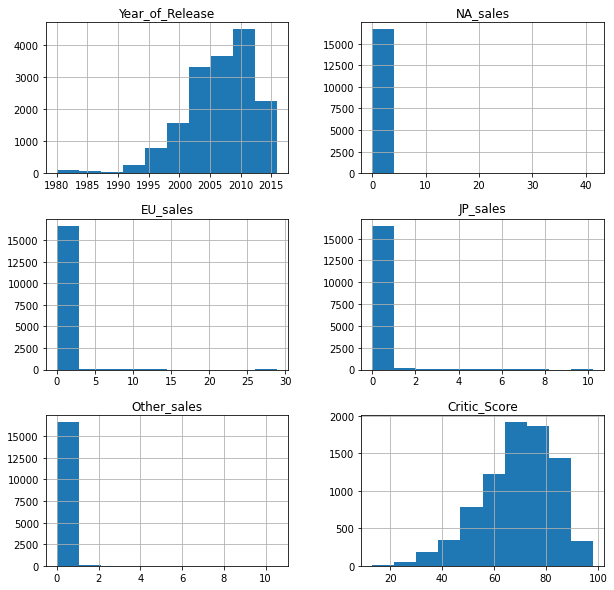

In [6]:
df.hist(figsize=(10, 10))
plt.show()

В колонках с продажами нули сильно искажают картину, ненулевые показатели не видно.

### Вывод

Файл с данными содержит 16715 записей и 11 колонок. 
В датафрейме обнаружены следующие проблемы:
- необходимо изменить названия столбцов - привести их к нижнему регистру;
- данные имеют пропуски в колонках: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating;
- кололку Year_of_Release необходимо привести к типу данных datetime(year) или int;
- у колонки User_Score тип данных object, нужно разобраться почему так произошло и, по возможности, привести к типу данных float;
- в колонках NA_sales, EU_sales, JP_sales и Other_sales нет NaN значений, но вместо них стоят нули, необходимо будет на следующем этапе выяснить, действительно ли это ноль, и тогда эту информацию нужно будет учитывать при дальнейшем анализе, либо это отсутствующие значения заполненные константой, тогда , чтобы они не искажали нам показатели, правильно будет заменить их на - NaN;
- судя по количеству уникальных значений в столбце Name, а именно по тому, что уникальных значений значительно меньше, чем строк в таблице, по некоторым строкам есть дублирующие записи с разной информацией. Нужно будет проверить действительно ли это дубли и, по возможности, объединить эти записи в одну.

## Предобработка данных

В этом разделе мы проверим и устраним проблемы, выявленные на этапе обзора данных, а также попробуем найти неявные дубликаты и аномалии в данных. \
Данные содержат пропуски и аномали, нам придется удалять часть данных, но чтобы провести релевантный анализ, нам нужно сохранить более 90% данных. Зафиксируем количество случаев перед предобработкой, чтобы в конце раздела понять, какой процент данных нам удалось сохранить. 

In [7]:
# Зафиксируем размер датафрейма
df_before = df.shape
df_before

(16715, 11)

### Изменим названия столбцов

In [8]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [9]:
# Проверим изменения
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Проверим наличе неявных дубликатов

Наличие явных дубликатов мы проверили на этапе обзора данных, поэтому сейчас проверим, нет ли неявных дубликатов из-за разного регистра. 

In [10]:
# Проверим, нет ли дубликатов из-за разного регистра
data = df.copy()
data['name'] = data['name'].str.lower()
len(data['name'].unique()) != len(df['name'].unique())

False

In [11]:
# Проверим, наличие неявных дубликатов совпадающих по названию, платформе и году релиза одновременно
df[df.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Первая строка, из-за Nan значения в названии дубликатом не является, т.к. много игр может быть выпущено в одном жанре и одном году, эту строку мы обработаем на этапе работы с пропусками. \
А вот строка 16230 является неявным дубликатом. Посмотрим на все строки с таким названием, индексом и годом.

In [12]:
# Посмотрим чем отличаются эти строки, найдем все
df.query('name == "Madden NFL 13" and platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Строка 16230 похожа на дубль ошибку выгрузки, удалим эту строку.

In [13]:
df = df.drop(index=16230)

# Проверим удаление
df.query('name == "Madden NFL 13" and platform == "PS3"').reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E


Более тщательно проверять наличие неявных дубликатов не будем, так как многие игры отличаются только цифрой в т.ч. буквенным ее обозначением (греческое обозначение цифр) - версией игры.

###  Изменим тип данных

#### в колонке year_of_release

Так как мы выяснили, что многие игры повторяются, мы можем проверить есть ли еще записи с этими играми, но с заполненным годом выпуска, и если это дубли - потом подтянуть эти года.

In [14]:
# Выберем все игры с пропусками в признаке year_of_release
nan_year_game_name = df[df['year_of_release'].isna()]['name'].unique()

# Найдем эти игры с заполненным полем year_of_release
df.query('name in @nan_year_game_name and not year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
32,Call of Duty: Black Ops,X360,2010.0,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
213,Madden NFL 06,PS2,2005.0,Sports,3.98,0.26,0.01,0.66,88.0,8,E
241,Madden NFL 07,PS2,2006.0,Sports,3.63,0.24,0.01,0.61,84.0,8.2,E
257,Sonic the Hedgehog,GEN,1991.0,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15961,Majesty 2: The Fantasy Kingdom Sim,PC,2009.0,Simulation,0.01,0.00,0.00,0.00,72.0,7.3,T
15971,Star Trek: Legacy,PC,2006.0,Simulation,0.00,0.01,0.00,0.00,56.0,4,E10+
16353,Aquaman: Battle for Atlantis,GC,2003.0,Action,0.01,0.00,0.00,0.00,27.0,3.1,T
16442,Dinotopia: The Sunstone Odyssey,XB,2003.0,Action,0.01,0.00,0.00,0.00,44.0,tbd,T


Как мы видим, игры отличаются платформой. Проверим, сколько уникальных year_of_release есть у одноименных игр на разных платформах. 

In [15]:
df.groupby(by='name')['year_of_release'].count().value_counts()

1     8678
2     1502
3      696
4      278
5      141
0      133
6       85
7       29
8       13
9        3
12       1
Name: year_of_release, dtype: int64

Таким образом, одну и ту же игру зпускали на разных платформах вплоть до в 12 разных годах, поэтому мы не можем заполнить пропуски с помощью этих случаев. Информация о годе выпуска критически важна для дальнейшего анализа, а количество строк с пропусками небольшое, поэтому просто удалим эти строки с пропусками. 

In [16]:
# Дополнительно посмотрим каким платформам принадлежат строки с пропусками, 
# так можно примерно понять одно время затронули пропуски в колонке year_of_release или нет
df[df['year_of_release'].isna()]['platform'].value_counts()

Wii     34
PS2     34
X360    30
DS      30
PS3     25
XB      21
PC      17
2600    17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
GB       1
PSV      1
Name: platform, dtype: int64

In [17]:
# Удалим пропуски
df = df.query('year_of_release.notna()').reset_index(drop=True)

# Проверим результативность
df['year_of_release'].isna().sum()

0

In [18]:
# Приведем к типу данных int
df['year_of_release'] = df['year_of_release'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16445 entries, 0 to 16444
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16445 non-null  object 
 2   year_of_release  16445 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16445 non-null  float64
 5   eu_sales         16445 non-null  float64
 6   jp_sales         16445 non-null  float64
 7   other_sales      16445 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


Пропуски в колонке year_of_release полностью случайные, они происходили у игр на платформах разных поколений, поэтому можно утверждать, что пропуски есть у игр, которые выпускались в разные года. \
Мы удалили все пропуски и поменяли тип данных на целочисленный. 

#### в колонке user_score       

Колонка user_score ('оценка пользователей') имеет тип данных object, нужно выяснить, почему так произошло и привести к числовому типу данных.

In [19]:
# Колонка user_score имеет пропуски, посмотрим в какие года были выпущены игры, у которых пропуски в этой колонке
df[df['user_score'].isna()]['year_of_release'].value_counts().sort_index()

1980      9
1981     46
1982     36
1983     17
1984     14
1985     13
1986     21
1987     16
1988     14
1989     17
1990     16
1991     41
1992     42
1993     62
1994    120
1995    219
1996    255
1997    270
1998    348
1999    299
2000    200
2001    143
2002    173
2003    164
2004    166
2005    235
2006    330
2007    376
2008    440
2009    407
2010    457
2011    418
2012    290
2013    225
2014    231
2015    271
2016    206
Name: year_of_release, dtype: int64

Данная колонка также имеет значительный процент пропусков (39.5% или 6607 случаев), пропуски есть в играх, которые выпускались в разные годы. Их восстановить не получиться, так как это поле подвержено человеческому фактору, заполнялось вручную и видимо было не обязательным, поэтому пропуски это просто отсутствие данных или некорректная их выгрузка. Оставим как есть, колонку приведем к типу данных float.

In [20]:
# Посмотрим уникальные значения в колонке
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

У части случаев оценка пользователей заполнена значением 'tbd' - аббревиатурой от английского To Be Determined (будет определено) или To Be Decided (будет решено). Она используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков. По сути, это отсутствие данных, поэтому заменим это обозначение на NaN.

In [21]:
# Приведем колонку к типу float, строковые типы данных будут принудительно заменены на NaN
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Проверим результат
df['user_score'].sort_values().unique()

array([0. , 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
       2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1,
       4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4,
       5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ,
       8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3,
       9.4, 9.5, 9.6, 9.7, nan])

### Обработаем пропуски

#### в колонке name

В этой колонке всего 2 пропуска, посмотрим на них.

In [22]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
652,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14022,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


У этих двух записей в половине колонок NaN значения, в том числе и в колонке genre. Название игр и жанр очень важны для нашего дальнейшего анализа, удалим их, таким образом сразу устранив все пропуски в обоих колонках.

In [23]:
# Удалим строки с пропусками в колонке 'name'
df = df.dropna(subset=['name'])

# Проверим результативность
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

#### в колонке critic_score

В этой колонке, как мы выяснили на этапе обзора данных, 51% пропусков. Посмотрим на случаи с пропусками и на корреляцию выборки с пропусками и остального датафрейма, проверим, нет ли закономерностей в появлении пропусков.

In [24]:
# Выведем на экран строки с пропусками в critic_score
df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16440,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16441,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16442,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16443,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [25]:
# Напишем функцию для нахождения пар колонок с максимальной корреляцией
def get_columns_with_max_correlation(data) -> list[dict[str: int]]:
    max_corr_list = []
    # чтобы не было ошибки, ограничим нужные колонки только числовыми
    columns = data.select_dtypes(include='number').columns
    for indx in range(len(columns)):
        correlation_temp = ['', 0]
        for indx2 in range(len(columns)):
            if columns[indx] != columns[indx2]:
                correlation = data[columns[indx]].corr(data[columns[indx2]])
                if correlation_temp[1] < abs(correlation):
                    correlation_temp = [columns[indx2], correlation]
        max_corr_list.append({columns[indx]: correlation_temp})
    return max_corr_list


# Выведем на экран общий список, где ключ словаря колонка, для которой ищем наиболее коррелирующую.
# Значение словаря - список из наиболее коррелирубщей колонки и размера корреляции.
get_columns_with_max_correlation(df)

[{'year_of_release': ['user_score', -0.2677447359969323]},
 {'na_sales': ['eu_sales', 0.7665450962333554]},
 {'eu_sales': ['na_sales', 0.7665450962333553]},
 {'jp_sales': ['na_sales', 0.4511593092598827]},
 {'other_sales': ['eu_sales', 0.7226781875425444]},
 {'critic_score': ['user_score', 0.5799197898468778]},
 {'user_score': ['critic_score', 0.5799197898468779]}]

In [26]:
# Посмотрим корреляцию для строк с пропусками в critic_score
get_columns_with_max_correlation(df[df['critic_score'].isna()])

[{'year_of_release': ['user_score', -0.25988719182530257]},
 {'na_sales': ['eu_sales', 0.6348795840166087]},
 {'eu_sales': ['other_sales', 0.756350421272126]},
 {'jp_sales': ['na_sales', 0.4815842512531648]},
 {'other_sales': ['eu_sales', 0.7563504212721261]},
 {'critic_score': ['', 0]},
 {'user_score': ['jp_sales', 0.09631367730204883]}]

Особых закономерностей в появлении пропусков в столбце critic_score нет, хотя у гереральной совокупности у этой колонки есть довольно сильная прямая зависимость от столбца user_score, что в целом не удивительно, критики и пользователи часто сходятся во мнениях. \
Посмотрим сколько строк с заполненным полем user_score есть у выборки с пропусками в столбце critic_score, возможно имеется неправильная выгрузка и пропуски в этих полях взаимосвязанны. 

In [27]:
df[df['critic_score'].isna()]['user_score'].count()

569

Нет, заполненные поля в столбце user_score есть. Так как у нас фрейм данных за несколько десятков лет (с 1989 г по 2016), возможно оценки пользователей и критиков стали собирать позднее. Посмотрим, какой процент от общего количества выпущенных игр в каждом году, имеют пропуски в столбце critic_score.

In [28]:
(
    df[df['critic_score'].isna()]['year_of_release'].value_counts().sort_index() / 
       df['year_of_release'].value_counts() * 100
)

1980    100.000000
1981    100.000000
1982    100.000000
1983    100.000000
1984    100.000000
1985     92.857143
1986    100.000000
1987    100.000000
1988     93.333333
1989    100.000000
1990    100.000000
1991    100.000000
1992     97.674419
1993    100.000000
1994     99.173554
1995    100.000000
1996     96.958175
1997     94.117647
1998     92.612137
1999     88.461538
2000     59.142857
2001     32.365145
2002     24.366707
2003     24.516129
2004     26.377953
2005     30.244941
2006     38.369781
2007     42.188805
2008     49.894884
2009     54.347826
2010     60.159363
2011     55.985915
2012     50.920245
2013     49.816176
2014     55.077453
2015     62.871287
2016     53.784861
Name: year_of_release, dtype: float64

До 2000-х пропусков действительно больше. \
Так как у нас фрейм данных по играм выпущенным на разных платформах, видимо не по всем платформам их создатели собирали отзывы критиков и пользователей. Посмотрим.

In [29]:
# Соберем две таблицы, в одной платформамы и количество случаев с пропусками по ним в поле critic_score
critic_score_isna = df[df['critic_score'].isna()]['platform'].value_counts().reset_index()

# во второй платформа и количество случаев с заполненным полем critic_score
critic_score_notna = df[df['critic_score'].notna()]['platform'].value_counts().reset_index()

# Склеим эти таблицы по индексу
merge_table = critic_score_isna.merge(critic_score_notna, on='index', how='outer')

# Переименуем столбцы
merge_table.columns = ['platform', 'isna_in_critic_score', 'notna_in_critic_score']

# Сделаем функцию для заполнения столбца, который покажет процент пропущенных значений от общеко количества игр платформы
def all_nan(row):
    if not math.isnan(row['isna_in_critic_score']) and math.isnan(row['notna_in_critic_score']):
        return 100
    elif math.isnan(row['isna_in_critic_score']) and not math.isnan(row['notna_in_critic_score']):
        return 0
    else:
        return row['isna_in_critic_score'] / (row['isna_in_critic_score'] + row['notna_in_critic_score']) * 100

# Создадим новый столбец, который покажет процент пропущенных значений от общеко количества игр платформы
# и применим на нем функцию
merge_table['percent_nan'] = merge_table.apply(all_nan, axis=1)

# Выведем на экран
merge_table

,platform,isna_in_critic_score,notna_in_critic_score,percent_nan
0,DS,1413,708.0,66.619519
1,PS,994,196.0,83.529412
2,PS2,852,1275.0,40.056417
3,PSP,737,456.0,61.777033
4,Wii,718,568.0,55.832037
5,PS3,502,803.0,38.467433
6,GBA,381,430.0,46.979038
7,3DS,346,166.0,67.578125
8,X360,338,894.0,27.435065
9,N64,316,NaN,100.000000


Как видим, у каждой платформы есть пропуски в поле critic_score, по многим из них количество таких случаев достигает 100%. Уверена, по пользовательским оценкам такая же ситуация. \
Оставим эти пропуски без изменений.

#### в колонке rating

Как мы выяснили на этапе обзора данных, в этой колонке 40% пропущенных значений. Посмотрим на случаи с пропусками.

In [30]:
# Выведем на экран строки с пропусками в rating
df[df['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16440,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16441,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16442,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16443,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Возможно одна и та же игра, выпущенная на разных платформах, имеет одинаковый рейтинг и мы можем заполнить часть значений на основании рейтинга с других платформ. Проверим.

In [31]:
# Сгруппируем выборку, где нет пропущенных значений в столбце rating, по названию, 
# выведем столбец с уникальными рейтингами каждой игры с разных платформ
data = df.query('rating.notna()').groupby('name').agg({'rating': 'unique'})

# Посчитаем количество вариаций рейтингов у каждой игры
data['unique_rating'] = data['rating'].apply(lambda x: len(x))

# Выведем на экран игры, у которых больше 1 уникального рейтинга
data.query('unique_rating > 1')

,rating,unique_rating
name,,
Astro Boy: The Video Game,"[E10+, E]",2
Avatar: The Last Airbender,"[E10+, E]",2
Barnyard,"[E10+, E]",2
Batman Begins,"[T, E10+]",2
Batman: Rise of Sin Tzu,"[T, E]",2
...,...,...
X2: Wolverine's Revenge,"[T, E]",2
Xiaolin Showdown,"[E10+, E]",2
Young Justice: Legacy,"[T, E10+]",2


In [32]:
# Посчитаем количество таких игр 
len(data.query('unique_rating > 1'))

169

Много. Мы не можем таким образом заполнить пропуски без риска искажения данных. \
Возможно рейтинг не присвоен очень старым играм или новым, которые еще не успели получить рейтинг, проверим.

In [33]:
# Посмотрим, в каком году был релиз игр с пропусками в рейтинге
df.query('rating.isna()')['year_of_release'].value_counts()

2010    456
2008    446
2011    433
2009    415
2007    376
1998    347
2006    328
2012    298
1999    296
2015    291
1997    270
1996    256
2014    236
2005    233
2013    228
2016    222
1995    219
2000    202
2002    174
2004    164
2003    162
2001    143
1994    120
1993     60
1981     46
1991     41
1992     41
1982     36
1986     21
1983     17
1989     17
1990     16
1987     16
1984     14
1988     14
1985     13
1980      9
Name: year_of_release, dtype: int64

Мы не можем достоверно заполнить пропуски этой категориальной переменной, удалять 40% данных мы тоже не будем, так как это категориальная, а не числовая переменная, заменим пропуски на 'unknown'.

In [34]:
# Заменим NaN на 'unknown'
df['rating'] = df['rating'].fillna('unknown')

# Проверим корректность заполнения
df.tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16440,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.0,NaN,NaN,unknown
16441,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.0,NaN,NaN,unknown
16442,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,unknown
16443,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.0,NaN,NaN,unknown
16444,Winning Post 8 2016,PSV,2016,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,unknown


### Проверим нули в колонках продаж

В колонках na_sales, eu_sales, jp_sales и other_sales нет NaN значений, но от 26 до 62 процентов случаев заполнено нулями. Эти нулевые значения, из-за их многочисленности, сильно искажают данные и меняют масштаб графиков так, что других результатов не видно. Для поиска причины выведем часть случаев с нулями в одном из столбцов, проверим в интернете, действительно ли данные игры не продавались в этих регионах.

In [35]:
# Проверим продажи в Японии, в этом столбце самое большое количество нулей
df.query('jp_sales == 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
61,Just Dance 3,Wii,2011,Misc,5.95,3.11,0.0,1.06,74.0,7.8,E10+
85,The Sims 3,PC,2009,Simulation,0.99,6.42,0.0,0.60,86.0,7.6,T
89,Pac-Man,2600,1982,Puzzle,7.28,0.45,0.0,0.08,NaN,NaN,unknown
100,Call of Duty: World at War,X360,2008,Shooter,4.81,1.88,0.0,0.69,84.0,7.6,M
103,Just Dance,Wii,2009,Misc,3.48,2.99,0.0,0.73,49.0,8.0,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16436,Men in Black II: Alien Escape,GC,2003,Shooter,0.01,0.00,0.0,0.00,NaN,NaN,T
16438,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.0,0.00,NaN,NaN,unknown
16439,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.0,0.00,NaN,NaN,unknown
16441,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.0,0.00,NaN,NaN,unknown


Проверив часть игр в интерне можно сделать вывод, что такое количество пропусков связано с частичными или полным переименованием игр на местный лад (например Just Dance в Японии издана как Just Danse Wii, а The Sims 3 издана как Дзя Симудзу 3. 

    ""В некоторых странах симулятор выпускался под другими названиями: так например в Германии игра вышла под названием Die Sims 3[55], в Испании, как Los Sims 3[56], Франции — Les Sims 3[57], Голландии, — De Sims 3[58], Японии — Дзя Симудзу 3 (яп. ザ・シムズ3 )[59], Южной Корее — Симджы 3 (кор. 심즈 3)[60] и Китае под названием Moни Шиминь (кит. упр. 模擬市民3)[61].""
    
Игры были изданы в тот же период, что и в других регионах, но с с другим названием, видимо поэтому сбор статистики не принес результата, и поэтому ноль - это не показатель плохих продаж, а константа отсутствия информации. \
В то же время, возможно, некоторые игры не были изданы в отдельных регионах, например я не нашла информацию по релизу игры Call of Duty: World at War в Японии, но ознакомившись с сюжетом, где Американцы воюют с Японской империей (главным злом), можно предположить, что релиза вовсе не было. Но даже тогда корректнее заменить нули на NaN.

In [36]:
# Заменим нули на NaN
df.loc[df['na_sales'] == 0, 'na_sales'] = np.nan
df.loc[df['eu_sales'] == 0, 'eu_sales'] = np.nan
df.loc[df['jp_sales'] == 0, 'jp_sales'] = np.nan
df.loc[df['other_sales'] == 0, 'other_sales'] = np.nan

# Оценим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16444
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         11995 non-null  float64
 5   eu_sales         10677 non-null  float64
 6   jp_sales         6144 non-null   float64
 7   other_sales      9952 non-null   float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [37]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16440,Samurai Warriors: Sanada Maru,PS3,2016,Action,NaN,NaN,0.01,NaN,NaN,NaN,unknown
16441,LMA Manager 2007,X360,2006,Sports,NaN,0.01,NaN,NaN,NaN,NaN,unknown
16442,Haitaka no Psychedelica,PSV,2016,Adventure,NaN,NaN,0.01,NaN,NaN,NaN,unknown
16443,Spirits & Spells,GBA,2003,Platform,0.01,NaN,NaN,NaN,NaN,NaN,unknown


### Посчитаем суммарные продажи по всем регионам и запишем их в отдельный столбец

In [38]:
# Добавим новый столбец с суммой продаж
df['sum_sales'] = df.loc[:, 'na_sales':'other_sales'].sum(axis=1)

In [39]:
# Првоерим
df.tail(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16435,15 Days,PC,2009,Adventure,NaN,0.01,NaN,NaN,63.0,5.8,unknown,0.01
16436,Men in Black II: Alien Escape,GC,2003,Shooter,0.01,NaN,NaN,NaN,NaN,NaN,T,0.01
16437,Aiyoku no Eustia,PSV,2014,Misc,NaN,NaN,0.01,NaN,NaN,NaN,unknown,0.01
16438,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,NaN,NaN,NaN,NaN,NaN,unknown,0.01
16439,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.00
16440,Samurai Warriors: Sanada Maru,PS3,2016,Action,NaN,NaN,0.01,NaN,NaN,NaN,unknown,0.01
16441,LMA Manager 2007,X360,2006,Sports,NaN,0.01,NaN,NaN,NaN,NaN,unknown,0.01
16442,Haitaka no Psychedelica,PSV,2016,Adventure,NaN,NaN,0.01,NaN,NaN,NaN,unknown,0.01
16443,Spirits & Spells,GBA,2003,Platform,0.01,NaN,NaN,NaN,NaN,NaN,unknown,0.01
16444,Winning Post 8 2016,PSV,2016,Simulation,NaN,NaN,0.01,NaN,NaN,NaN,unknown,0.01


In [40]:
# У нас есть случаи с нулевыми продажами, проверим сколько их
df[df['sum_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16406,G1 Jockey 4 2008,PS3,2008,Sports,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.0
16439,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.0


Удалим строки с пропусками во всех колонках продаж, оценок и рейтинга, они не несут для нас информационной ценности. 

In [41]:
# Удалим строки нулевым sum_sales
df = df.query('sum_sales > 0').reset_index(drop=True)

In [42]:
# В заключени посмотрим общую информацию по датафрейму после предобработки
dataframe_information(df)

,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,name,object,0,0,0.000000,11425,NaN,NaN,NaN,NaN,NaN,NaN,0
1,platform,object,0,0,0.000000,31,NaN,NaN,NaN,NaN,NaN,NaN,0
2,year_of_release,int64,0,0,0.000000,37,0.0,2006.485737,5.875880,1980.00,2016.00,305.0,0
3,genre,object,0,0,0.000000,12,NaN,NaN,NaN,NaN,NaN,NaN,0
4,na_sales,float64,4446,0,27.042151,401,0.0,0.361936,0.939536,0.01,41.36,1271.0,0
5,eu_sales,float64,5764,0,35.058695,307,0.0,0.224751,0.614608,0.01,28.96,1150.0,0
6,jp_sales,float64,10297,0,62.630010,244,0.0,0.210065,0.481057,0.01,10.22,672.0,0
7,other_sales,float64,6489,0,39.468402,155,0.0,0.078640,0.236567,0.01,10.57,1016.0,0
8,critic_score,float64,8459,0,51.450642,82,0.0,68.992608,13.920049,13.00,98.00,80.0,0
9,user_score,float64,8979,1,54.619549,96,0.0,7.126548,1.499429,0.00,9.70,299.0,0


In [43]:
# Посмотрим, какой процент данных нам удалось сохранить
'Удалось сохранить {:.1%} процента данных.'.format(df.shape[0] / df_before[0])

'Удалось сохранить 98.4% процента данных.'

### Вывод:

В ходе предобработки данных мы сделали следующее:
- изменили названия столбцов - привели их к нижнему регистру;
- проверили наличие неявных дубликатов;
- изменили тип данных в колонках year_of_release и user_score, привели их к целочисленным и вещественным типам данных соответственно;
- обработали пропуски в колонках name, genre, critic_score и rating;
- добавили новый признак - столбец sum_sales (сумму продаж);
- заменили нули на NaN (неизвестное число), чтобы не было искажения такого сильного влияния на центр данных.
После обработки данных, нам удалось сохранить 98.4 процента данных.
Необходимо обратить внимание программистов на то, что большая доля продаж не была выгружена и была заменена на нули. Мы предположили, что так произошло из-за изменения названия игры в стране релиза, поэтому продажи для не были выгружены корректно. Необходимо поправить модели БД и добавить возможнось вместо нулей проставлять NaN значения.

## Исследовательский анализ данных

В этом разделе мы проведем следующие работы и ответим на вопросы:
- Сколько игр выпускалось в разные годы и важны ли данные за все периоды.
- Посмотрим, как менялись продажи по платформам, выберирем платформы с наибольшими суммарными продажами и построим распределение по годам. Узнаем за какой характерный срок появляются новые и исчезают старые платформы.
- Уточним, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.
- Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.
- Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.
- Соотнесем выводы с продажами игр на других платформах. 
- Посмотрим на общее распределение игр по жанрам. Вылелим самые прибыльные жанры. Узначем, выделяются ли жанры с высокими и низкими продажами.

###  Сколько игр выпускалось в разные годы и важны ли данные за все периоды.

In [44]:
# Посмотрим, сколько игр выпускалось в каждый год
df.groupby(by='year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1425
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Визуализируем.

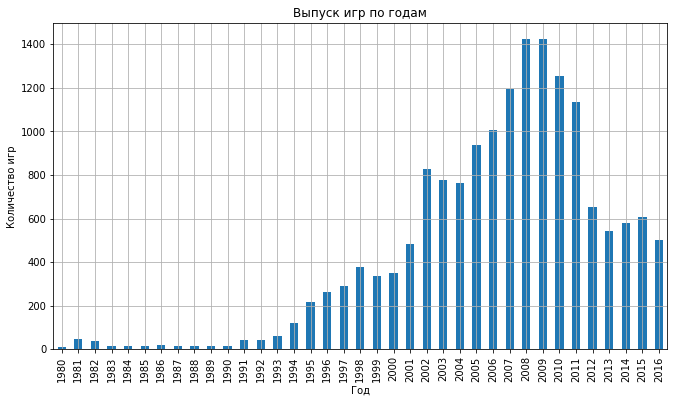

In [45]:
plt.figure(figsize=(11, 6))
df.groupby('year_of_release')['name'].count().plot(kind='bar', grid=True)
plt.title('Выпуск игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

В 2008 и 2009 году выпустили больше всего игр - 1425 и 1426 соответственно. До 1994 года выпускали менее 100 игр в год. С 2005 по 2011 в год выпускали больше всего игр. После 2011 года количество выпущенных игр стало уменьшаться так, что распределение напоминает биномиальное. В связи с этим, считаю актуальным периодом данные за последние 4 года - с 2012 по 2016 (хоть за него данные и неполные, но это наиболее актуальный год, что критично).

### Как менялись продажи по платформам

In [46]:
# Выведем количество игр выпущенных для каждой платформы. Отсортируем по количеству случаев.
df['platform'].value_counts()

PS2     2126
DS      2121
PS3     1304
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [47]:
# Посмотрим продажи по каждой платформе
platform_sales = (df.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
                    .sort_values(by='sum_sales', ascending=False).reset_index())
platform_sales

,platform,sum_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Визуализируем. 

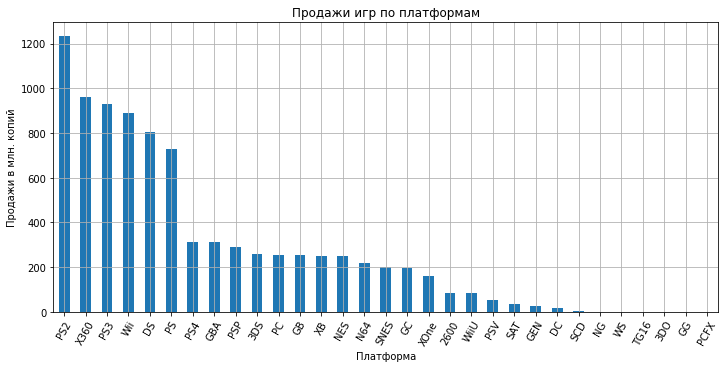

In [48]:
platform_sales.plot(x='platform', y='sum_sales', kind='bar', figsize=(10, 5), legend=False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.title('Продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн. копий')
plt.grid()
plt.show()

Наибольшее количество копий игр было продано для платформы PS2 - 1233 млн. копий. Второе место занимает X360 - 961.24 млн. копий. На третьем месте PS3 с 931.34 млн. копий. Примечательно, что в топ-6 платформ вошли 3 платформы линейки Play Station, а в топ-10 этих платформ 5 штук.

Визуализируем продажи игр по годам для первых шести платформ. 

In [49]:
# Отберем имена первых шести платформ
top_platform = list(platform_sales['platform'][:6])
top_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

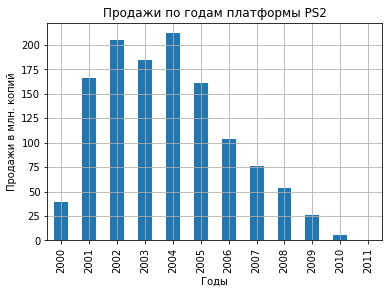

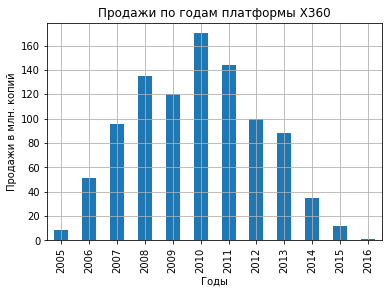

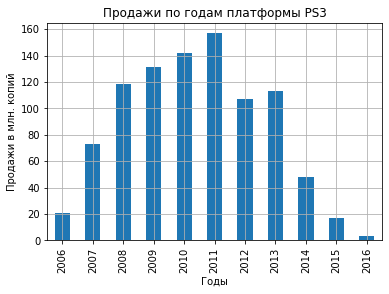

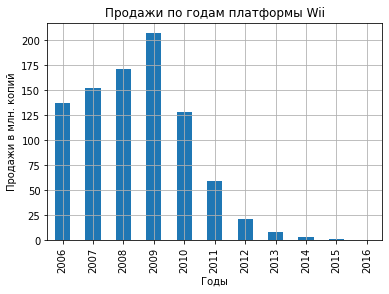

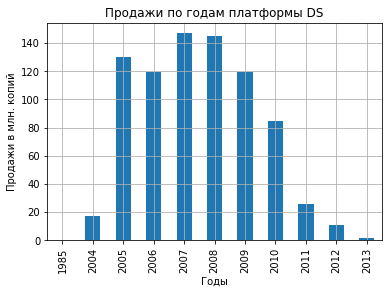

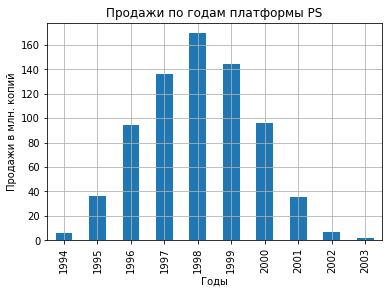

In [50]:
# Отберем только нужную нам информацию: платформа, годы, когда производились продажи и сумму продаж в каждом году
platform_pivot = (df.query('platform in @top_platform')
                    .groupby(by=['platform', 'year_of_release'])
                    .agg({'sum_sales': 'sum'})
                    .reset_index())

for platform in top_platform:
    platform_pivot.query('platform == @platform').plot(x='year_of_release',
                                                       y='sum_sales',
                                                       kind='bar',
                                                       legend=False)
    plt.title(f'Продажи по годам платформы {platform}')
    plt.xlabel('Годы')
    plt.ylabel('Продажи в млн. копий')
    plt.grid()
    plt.show()

У платформы DS есть ненулевое количество проданных игр в 1985 году, что является выбросом, так как саму платформу выпустили только в 2004 году. Посмотрим, сколько таких случаев и удалим их.

In [51]:
# Посмотрим сколько таких случаев
df.query('platform == "DS" and year_of_release < 2000')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
15704,Strongest Tokyo University Shogi DS,DS,1985,Action,NaN,NaN,0.02,NaN,NaN,NaN,unknown,0.02


In [52]:
# Удалим этот случай
df = df.drop(index=15704).reset_index(drop=True)

# Проверим резултативность
df.query('platform == "DS" and year_of_release < 2000')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales


Посмотрим, сколько лет существовала каждая платформа.

In [53]:
platform_life = df.groupby('platform').agg({'year_of_release' : ['min', 'max']})

platform_life['life_cycle'] = platform_life['year_of_release', 'max'] - platform_life['year_of_release', 'min']

platform_life

year_of_release       life_cycle
                     min   max           
platform                                 
2600                1980  1989          9
3DO                 1994  1995          1
3DS                 2011  2016          5
DC                  1998  2008         10
DS                  2004  2013          9
GB                  1988  2001         13
GBA                 2000  2007          7
GC                  2001  2007          6
GEN                 1990  1994          4
GG                  1992  1992          0
N64                 1996  2002          6
NES                 1983  1994         11
NG                  1993  1996          3
PC                  1985  2016         31
PCFX                1996  1996          0
PS                  1994  2003          9
PS2                 2000  2011         11
PS3                 2006  2016         10
PS4                 2013  2016          3
PSP                 2004  2015         11
PSV                 2011  2016          5
SAT                 1994  1999          5
SCD                 1993  1994          1
SNES                1990  1999          9
TG16                1995  1995          0
WS                  1999  2001          2
Wii                 2006  2016         10
WiiU                2012  2016          4
X360                2005  2016         11
XB                  2000  2008          8
XOne                2013  2016          3

In [86]:
# код ревьюера
df.groupby('platform').agg({'year_of_release' : 'nunique'}).mean()

year_of_release    7.645161
dtype: float64

In [54]:
platform_life['life_cycle'].mean()

7.0

Cудя по истарическим данным, в среднем платформы появляются и исчезают за 7 лет.

### Уточним, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

In [55]:
# Возьмем данные за актуальный период c 2012 по 2016 текущий год
actual_period = df.query('year_of_release >= 2012')

Посмотрим какие платформы присутствуют на рынке в этот период и сколько игр по ним выпущено в каждом году. 

In [56]:
actual_period_pivot = actual_period.pivot_table(index='year_of_release',
                                                values='name',
                                                columns='platform',
                                                aggfunc='count')
actual_period_pivot

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,93.0,23.0,61.0,147.0,NaN,106.0,53.0,31.0,32.0,106.0,NaN
2013,91.0,8.0,38.0,126.0,16.0,54.0,63.0,12.0,42.0,75.0,19.0
2014,80.0,NaN,47.0,108.0,75.0,10.0,100.0,6.0,31.0,63.0,61.0
2015,86.0,NaN,50.0,73.0,137.0,3.0,110.0,4.0,28.0,35.0,80.0
2016,46.0,NaN,54.0,38.0,164.0,NaN,85.0,1.0,14.0,13.0,87.0


Сформируем тепловую карту.

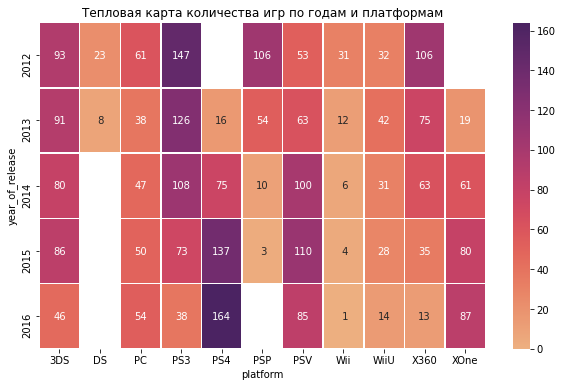

In [57]:
plt.figure(figsize=(10,6))
sns.heatmap(actual_period_pivot, linewidths=.5,annot=True,fmt='2.0f',vmin=0, cmap='flare')
plt.title('Тепловая карта количества игр по годам и платформам')
plt.show()

На тепловой карте видно, что:
1) Платформы 3DS, PS3, Wii, WiiU, X360 и PSV находятся на закате своего жизненного цикла, динамика выхода игр отрицательная с каждым годом.
2) Платформы DS, PSP окончательно устарели - игры на них больше не производятся.
3) Платформa PS - стаблильный среднячок. Благодаря тому, что портативные компьютеры не статичны в плане производительности, так как их комплектующие постоянно обновляются и совершенствуются, поэтому на них регулярно выпускаются игры, хоть и в меньшем объеме, чем на портативные консоли.
4) Платформы PS4 и XOne находятся в середине своего жизненного цикла, на пике, и в данной выборке являются наиболее перспективными.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

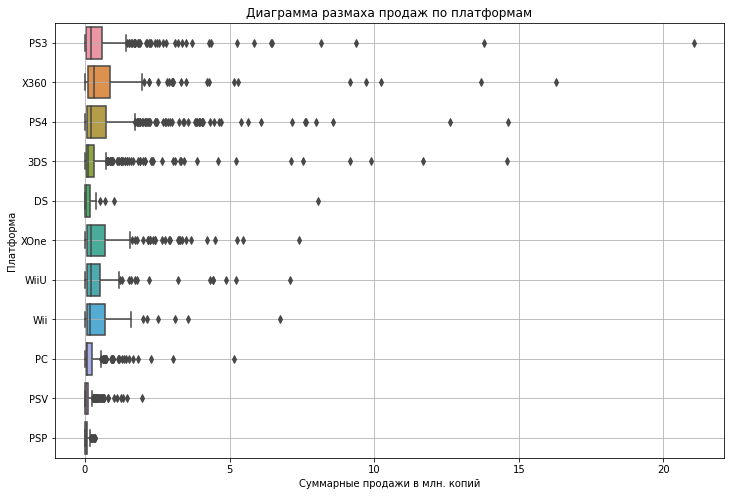

In [58]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    data = actual_period,
    y = 'platform',
    x = 'sum_sales', 
) 
plt.title('Диаграмма размаха продаж по платформам')
plt.xlabel('Суммарные продажи в млн. копий')
plt.grid()
plt.ylabel('Платформа');

Содержание ящиков плохо видно. Уберем выбросы. 

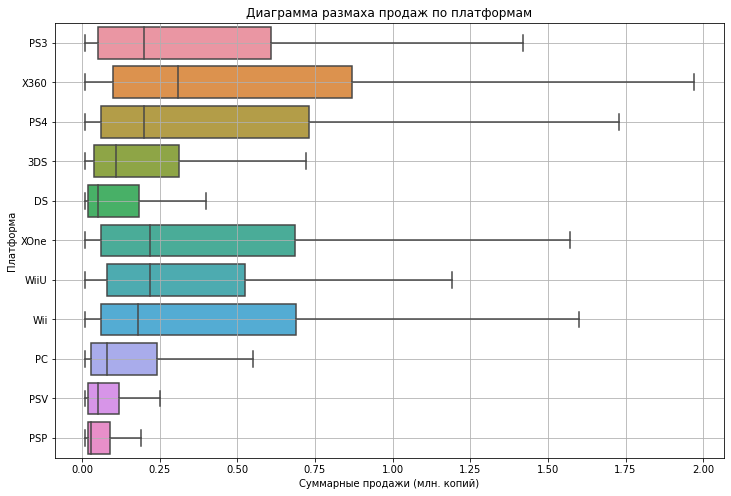

In [59]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    data = actual_period,
    y = 'platform',
    x = 'sum_sales', 
    showfliers = False,
) 
plt.title('Диаграмма размаха продаж по платформам')
plt.xlabel('Суммарные продажи (млн. копий)')
plt.grid()
plt.ylabel('Платформа');

Судя по графику, наиболее кассовой платформой является X360, но как мы выявили ранее - жизненный цикл этой платформы заканчивается. 

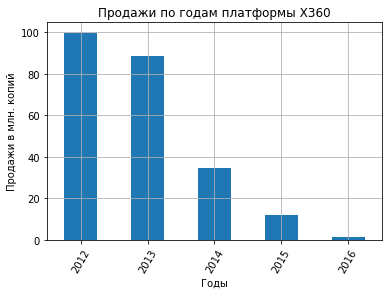

In [60]:
# Выведем график продаж платформы Х360 по годам, 
# но так как мы еще несколько раз будем пользоваться этим алгоритмом, 
# чтобы не повторяться, сразу напишем функцию 
def get_sales_barplot_by_years(df, platform):
    (
        df.query('platform == @platform')
          .groupby(by=['platform', 'year_of_release'])
          .agg({'sum_sales': 'sum'})
          .reset_index()
    ).plot(x='year_of_release',
           y='sum_sales',
           kind='bar',
           legend=False)
    plt.title(f'Продажи по годам платформы {platform}')
    plt.xlabel('Годы')
    plt.ylabel('Продажи в млн. копий')
    plt.xticks(rotation=60)
    plt.grid()
    plt.show()
    

get_sales_barplot_by_years(actual_period, 'X360')

Следующими идут платформы PS4, XOne и Wii. Как мы выявили ранее первые две - на пике количества выпускаемых игр, а Wii заканчивает свой жизненный цикл -  с каждым годом количество выпускаемых игр все меньше. 
Визуализируем. 

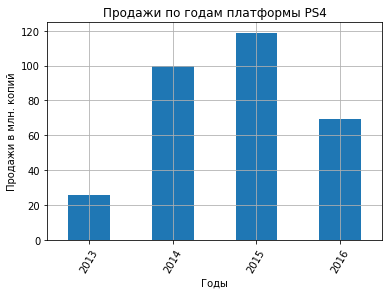

In [61]:
# Выведем график продаж по годам платформы PS4
get_sales_barplot_by_years(actual_period, 'PS4')

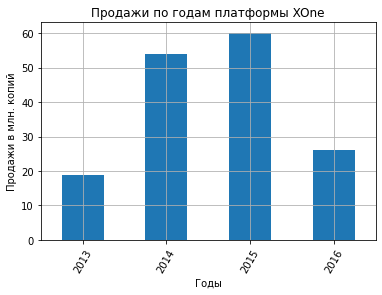

In [62]:
# Выведем график продаж по годам платформы XOne
get_sales_barplot_by_years(actual_period, 'XOne')

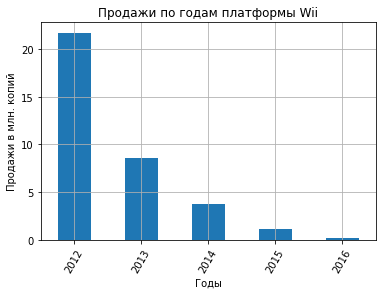

In [63]:
# Выведем график продаж по годам платформы XOne
get_sales_barplot_by_years(actual_period, 'Wii')

Стоит напомнить, что данные за 2016 год являются неполными, а также, что по PS4 и по XOne было выпущено большое количество игр в 2016 году (164 и 87 соответственно), поэтому эти игры еще в полной мере не отразили свои продажи в графиках. Считаю, что после прогрузки полных данных, проажи за 2016 год по платформам PS4 и XOne превзойдут показатели за 2015 год, и что на 2017 год эти платормы наиболее перспективны.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

Для этого построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для примера возьмем самую кассовую платформу - Х360.

Корреляция с платформой X360 равна 0.3605734888507336


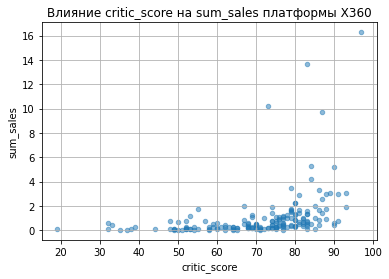

In [64]:
# Так как нам в дальнейшем нужно будет несколько раз выводить график с долей корреляции, напишем функцию
def get_corr_scatter(df, platform, corr_columns1, corr_columns2):
    data_platform = df.query('platform == @platform')
    print(f'Корреляция с платформой {platform} равна {data_platform[corr_columns1].corr(data_platform[corr_columns2])}')
    data_platform.plot(x=corr_columns1,
                       y=corr_columns2,
                       grid=True,
                       figsize=(6, 4),
                       kind='scatter',
                       alpha=0.5)
    plt.title(f'Влияние {corr_columns1} на {corr_columns2} платформы {platform}')
    plt.show()

# Выведем на экран корреляцию оценок критиков на игры платформы X360 на сумму продаж
get_corr_scatter(actual_period, 'X360', 'critic_score', 'sum_sales')

Мы видим, что начиная где то с 73 баллов, на продажи части игр начинает влиять оценка критиков - чем выше оценка,тем лучше продажи. 

Корреляция с платформой X360 равна 0.006163978646213326


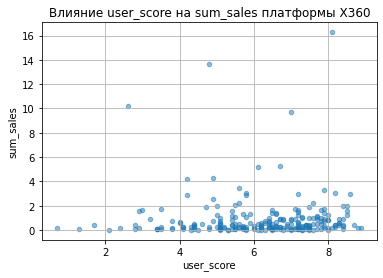

In [65]:
# Посмотрим корреляцию оценок пользователей и суммы продаж
get_corr_scatter(actual_period, 'X360', 'user_score', 'sum_sales')

Зависимости между оценкой пользователи и продажами нет.

Посмотрим влияние оценок у других платформ.

Корреляция с платформой PS4 равна 0.40656790206178095


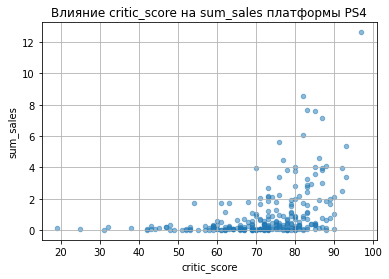

In [66]:
# Выведем на экран корреляцию оценок критиков на игры платформы PS4 на сумму продаж
get_corr_scatter(actual_period, 'PS4', 'critic_score', 'sum_sales')

Корреляция с платформой PS4 равна -0.031957110204556376


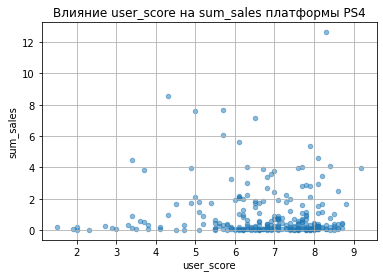

In [67]:
# Посмотрим корреляцию оценок пользователей и суммы продаж
get_corr_scatter(actual_period, 'PS4', 'user_score', 'sum_sales')

Корреляция с платформой XOne равна 0.4169983280084017


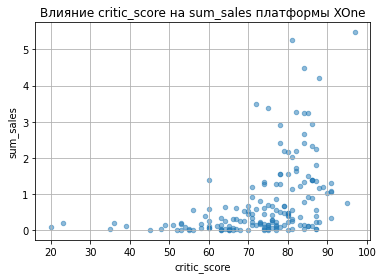

In [68]:
# Выведем на экран корреляцию оценок критиков на игры платформы XOne на сумму продаж
get_corr_scatter(actual_period, 'XOne', 'critic_score', 'sum_sales')

Корреляция с платформой XOne равна -0.06892505328279414


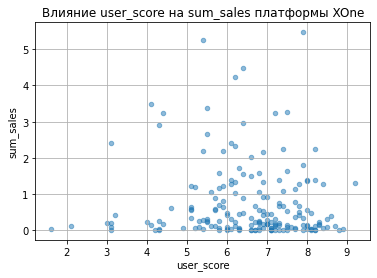

In [69]:
# Посмотрим корреляцию оценок пользователей и суммы продаж
get_corr_scatter(actual_period, 'XOne', 'user_score', 'sum_sales')

Как мы видим, картина аналогичная, корреляция между оценками пользователей и суммой продаж околонулевая, в то же время есть слабая корреляция между оценками критиков и продажами - в районе 40%. Тоесть зависимость сложная, но прямая.

### Посмотрим на распределение игр по жанрам

In [70]:
actual_period.value_counts('genre')

genre
Action          1031
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
dtype: int64

Визуализируем.

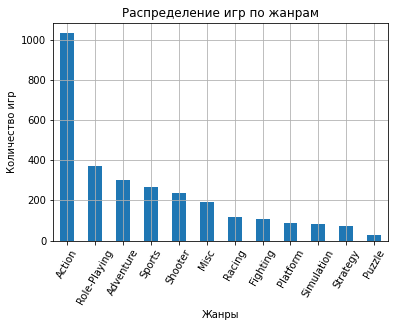

In [71]:
actual_period.value_counts('genre').plot(kind='bar')
plt.title(f'Распределение игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество игр')
plt.xticks(rotation=60)
plt.grid()
plt.show()

Самое большое количество игр выпускают в жанре Action, на втором и третьих местах Role-Playing и Adventure, самое меньшее количество игр выпускают в жанре Puzzle.

In [72]:
# Посмотрим сколько в среднем млн копий одной игры продают в каждом жанре
actual_period.pivot_table(index='genre', values='sum_sales', aggfunc='mean').sort_values('sum_sales', ascending=False)

,sum_sales
genre,
Shooter,1.296723
Platform,0.717647
Sports,0.678127
Role-Playing,0.521081
Racing,0.465217
Misc,0.442917
Simulation,0.439000
Action,0.427856
Fighting,0.408165


Визуализируем.

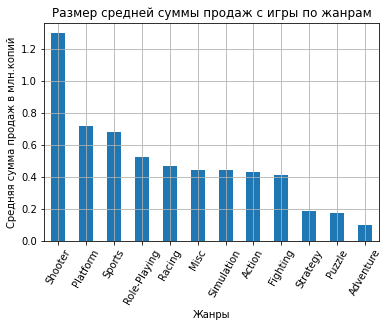

In [73]:
(
    actual_period.pivot_table(index='genre', values='sum_sales', aggfunc='mean')
    .sort_values('sum_sales', ascending=False)
    .plot(kind='bar', legend=False)
)
plt.title(f'Размер средней суммы продаж с игры по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Средняя сумма продаж в млн.копий')
plt.xticks(rotation=60)
plt.grid()
plt.show()

Самое большое среднее количество копий одной игры продают в жанре Shooter, на втором и третьем местах жанры Platform и Sports, самое меньшее среднее количество копий продают в жанре Adventure.

Таким образом самым перспективным выбором для рекламной компании являются игры в жанрах Shooter и Platform. Эти игры хорошо продаются, а также благодаря ограниченному предложению (наименований), в рекламной компании можно сосредоточиться на небольшом количестве игр.

### Вывод:

Мы провели исследовательский анализ и выяснили, что:
- В 2008 и 2009 году выпустили больше всего игр - 1425 и 1426 соответственно. До 1994 года выпускали менее 100 игр в год. С 2005 по 2011 в год выпускали больше всего игр. После 2011 года количество выпущенных игр стало уменьшаться так, что распределение напоминает биномиальное, поэтому актуальным периодом мы выбрали данные за 2012 по 2016 год включительно. 
- Наибольшее количество копий игр было продано для платформы PS2 - 1233 млн. копий. Второе место занимает X360 - 961.24 млн. копий. На третьем месте PS3 с 931.34 млн. копий. Примечательно, что в топ-6 платформ вошли 3 платформы линейки Play Station, а в топ-10 этих платформ 5 штук.
- Средний срок жизни платформы - 7 лет.
- Построили тепловую карту, где мы увидели, что:
  1) Платформы 3DS, PS3, Wii, WiiU, X360 и PSV находятся на закате своего жизненного цикла, динамика выхода игр отрицательная с каждым годом.
  2) Платформы DS, PSP окончательно устарели - игры на них больше не производятся.
    3) Платформa PS - стаблильный среднячок. Благодаря тому, что портативные компьютеры не статичны в плане производительности, так как их комплектующие постоянно обновляются и совершенствуются, поэтому на них регулярно выпускаются игры, хоть и в меньшем объеме, чем на портативные консоли.
    4) Платформы PS4 и XOne находятся в середине своего жизненного цикла, на пике, и в данной выборке являются наиболее перспективными.
- Мы рассмотрели графики и выяснили, что наиболее кассовой консолью является X360, но как мы выявили ранее - жизненный цикл этой платформы заканчивается. Следующими идут консоли PS4, XOne и Wii. Как мы выявили ранее первые две - на пике количества выпускаемых игр, а Wii заканчивает свой жизненный цикл -  с каждым годом количество выпускаемых игр все меньше. Стоит напомнить, что данные за 2016 год являются неполными, а также, что по PS4 и по XOne было выпущено большое количество игр в 2016 году (164 и 87 соответственно), поэтому эти игры еще в полной мере не отразили свои продажи в графиках. Думаю, что после прогрузки полных данных, проажи за 2016 год по платформам PS4 и XOne превзойдут показатели за 2015 год, и что на 2017 год эти платормы наиболее перспективны.
- Измерив корреляцию между продажами и отывами критиков и пользователей, мы выяснили, что отзывы пользователей не влияют на продажи, а отзывы критиков имеют слабое влияние на продажи, размер корреляции составил 40%. Рассмотрев графики рассеяния, мы увидели, что начиная с оценки критиков около 72 баллов, на продажи части игр оценка начинает влиять на продажи - чем оценка выше, тем больше продажи. То есть зависимость между продажами и оценками критиков сложная, но прямая. 
- Самое большое количество игр выпускают в жанре Action, на втором и третьих местах Role-Playing и Adventure, самое меньшее количество игр выпускают в жанре Puzzle. Самое большое среднее количество копий одной игры продают в жанре Shooter, на втором и третьем местах жанры Platform и Sports, самое меньшее среднее количество копий продают в жанре Adventure. Таким образом самым перспективным выбором для рекламной компании являются игры в жанрах Shooter и Platform. Эти игры хорошо продаются, а также благодаря ограниченному предложению (наименований), в рекламной компании можно сосредоточиться на небольшом количестве игр.

Подытожим, самым перспективным выбором для продвижения в 2017 году являются игры на консолях PS4 и XOne, в жанрах Shooter, Platform и Sports и рейтингом критиков более 72 баллов.

## Составим портрет пользователя каждого региона

В этом разделе мы посмотрим, какие платформы, жанры пользуются спросом в каждом регионе, а также влияет ли рейтинг ESRB на продажи в отдельном регионе. Это поможет нам понять, есть ли региональная локализация предпочтений, требуется ли под каждый регион выбирать свой ассортимент для продвижения. 

### Топ платформ в каждом регионе

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


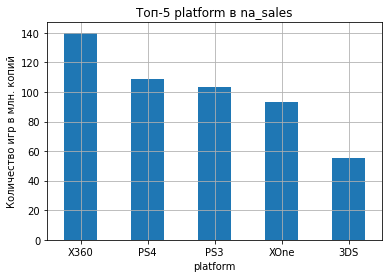

In [74]:
# Напишем функцию для визуализации нужной нам информации.
def get_top(df, column_name, column_sales):
    df_pivot = (df.pivot_table(index=column_name, values=column_sales, aggfunc='sum')
                  .sort_values(by=column_sales, ascending=False)[:5])
    display(df_pivot)
    df_pivot.plot(kind='bar', legend=False)
    plt.title(f'Топ-5 {column_name} в {column_sales}')
    plt.ylabel('Количество игр в млн. копий')
    plt.xticks(rotation=0)
    plt.grid()

# Выведем топ платформ в Северной Америке
get_top(actual_period, 'platform', 'na_sales')

Топ 1 в Северной Америке занимает приставка X360, второе и третье место принадлежит консолям семейства PlayStation четвертой и третьей весии, далее идет XOne и 3DS.

,eu_sales
platform,
PS4,141.09
PS3,106.85
X360,74.52
XOne,51.59
3DS,42.64


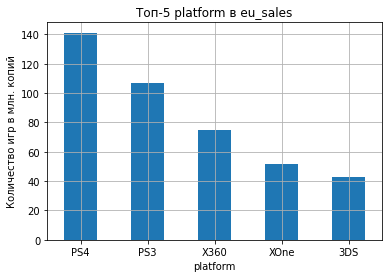

In [75]:
# Выведем топ платформ в Европе
get_top(actual_period, 'platform', 'eu_sales')

Первое и второе место в Европе принадлежит консолям семейства PlayStation  четвертой и третьей весии, на третьем месте X360, далее идет XOne и 3DS. Отличия Европы и Америки в месте X360, в Америке она на первом месте, в Европе на третьем.

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


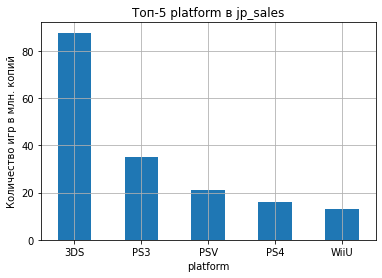

In [76]:
# Выведем топ платформ в Японии
get_top(actual_period, 'platform', 'jp_sales')

У Японцев совершенно другая картина, первое место занимает платформа 3DS (в Европе и Америке она на последнем месте), далее идет три продукта марки PlayStation, причем третья версия, в отличии от Европы с Америкой, находится выше, чем четвертая версия, также в топ рейтинга появился новый продукт - PSV, ручная портативная консоль. Последнее место занимает WiiU, тоже новый продукт в топе. В отличии от Европы с Америкой, в топ платформ отсутствуют консоли Х360 и XOne. Также видно, что в сумме в Японии продано меньше игр, чем в Европе или Америке, топ1 продано всего 87 млн, против 140 млн в Америке и 141 млн в Европе. \
Данные так сильно отличаются скорее всего из-за большого количества пропусков в колонке продаж (62%).

### Топ жанров в каждом регионе.

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


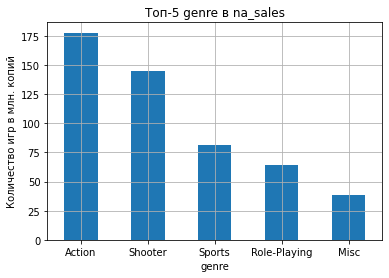

In [77]:
# Выведем топ жанров в Северной Америке
get_top(actual_period, 'genre', 'na_sales')

В Северной Америке топ1 занимает жанр Action, далее идет жанр Shooter, третье место принадлежит жанру Sports и на четвертом и пятом месте Role-Playing и Misc соответственно.

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.08
Role-Playing,48.53
Racing,27.29


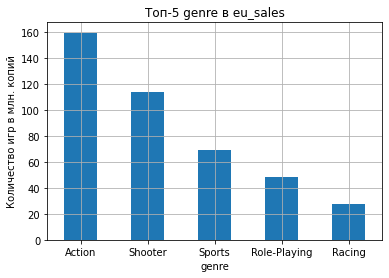

In [78]:
# Выведем топ жанров в Европе
get_top(actual_period, 'genre', 'eu_sales')

В Европе первые четыре места аналогично занимают жанры Action, Shooter, Sports и Role-Playing, отличие от Северной Америки заключается в позиции на пятом месте - жанре Racing.

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


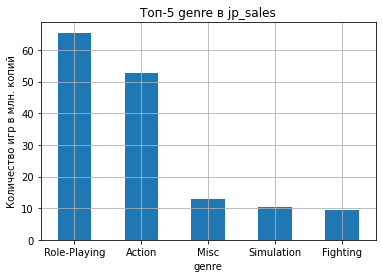

In [79]:
# Выведем топ жанров в Японии
get_top(actual_period, 'genre', 'jp_sales')

Как и в ситуации с платформами, в жанрах Япония сильно отличается от Еропы с Северной Америкой: перрое место занимает жанр Role-Playing, на втором месте жанр Action (занимающий первые места в СА и Европе), далее идет жанр Misc, на четвертом и пятых местах отсутствующие в топах СА и Европы жанры Simulation и Fighting.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [80]:
# Посмотрим сколько уникальных значений рейтинга есть в актульном периоде
actual_period['rating'].unique()

array(['M', 'unknown', 'E', 'E10+', 'T'], dtype=object)

Расшифруем значения:
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.
- «E» («Everyone») — «Для всех»: Такие игры подходят для все возрастов.
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
- «unknown» - так мы пометили игры, рейтинг для которых неизвестен.

,na_sales
rating,
M,231.57
E,114.37
unknown,103.31
E10+,75.70
T,66.02


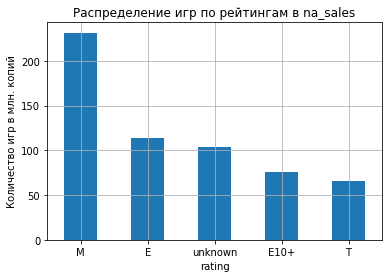

In [81]:
# Напишем функцию для визуализации нужной нам информации.
def get_rating(df, column_sales):
    df_pivot = (df.pivot_table(index=df['rating'], values=column_sales, aggfunc='sum')
                  .sort_values(by=column_sales, ascending=False)[:5])
    display(df_pivot)
    df_pivot.plot(kind='bar', legend=False)
    plt.title(f'Распределение игр по рейтингам в {column_sales}')
    plt.ylabel('Количество игр в млн. копий')
    plt.xticks(rotation=0)
    plt.grid()

# Выведем топ рейтингов в Северной Америке
get_rating(actual_period, 'na_sales')

Лучше всего в Северной Америке продаются игры с рейтингом М (для взрослых), второе место занимают игры с рейтингом Е (для всех), третье метсто у неопознанного рейтинга, на четвертом и пятом месте игры с рейтингом Е10+ (от 10 лет и старше) и Т (от 13 лет).

,eu_sales
rating,
M,193.96
E,113.02
unknown,91.50
E10+,55.37
T,52.96


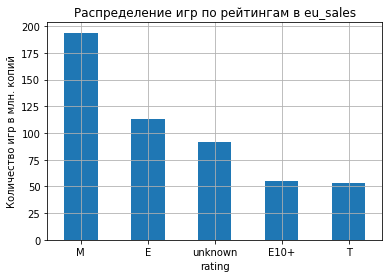

In [82]:
# Выведем топ рейтингов в Европе
get_rating(actual_period, 'eu_sales')

В Европе предпочтения такие же как и в Северной Америке, топ занимают те же игры, в том же порядке. Отличаются только обьемы: игры рейтинга М продаются примерно на 15% лучше, также лучше продаются игры с рейтингами Е10+ и Т.

,jp_sales
rating,
unknown,108.84
E,28.33
T,26.02
M,21.20
E10+,8.19


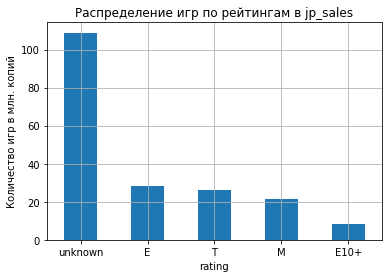

In [83]:
# Выведем топ платформ в Японии
get_rating(actual_period, 'jp_sales')

Японцы как всегда выделяются. На первом месте расположен неизвестный рейтинг, на втором месте игры с рейтингом Е (для всех), четвертое и пятые места занимают игры с рейтингами М (для взрослых) и игры с рейтингом Е10+ (от 10 лет).

### Вывод:

Мы исследовали особенности продаж в регионах Серверная Америка, Европа и Япония, и теперь можем составить портрет пользвателя в каждом регионе. 

Типичный пользователь Северной Америки играет на приставке Х360, реже на PS4, любимые его жанры это Action и Shooter, рейтинг у этих игр M (для взрослых), в два раза реже Е (для всех). 

Средний Европейский пользователь выбирает консоли семейства PlayStation 4ой или 3ей серии, любимые жанры у него - Action и Shooter, рейтинг у этих игр M (для взрослых), реже Е (для всех). 

Стандартный японский геймер выбирает консоли 3DS, реже PS3, любимые его жанры Role-Playing или Action, рейтинг у большинства этих игр неизвестен, но намного реже (в 4 раза реже) он выбирает игры рейтинга E (для всех). Стоит отметить, что у Японцев есть свое рейтинговое агенство(CERO), и на рейтинг ESRB, который является американским, они слабо ориентируются. Видимо большое количество игр с неизвестным рейтингом связано именно с этим, т.к. обозначения рейтинга и градация у японцев другая.

## Проверка гипотез

В этом разделе мы проверим ряд гипотез, а именно:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформируем нулевую и альтернативную гипотезу:
- Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Н1: Средние пользовательские рейтинги платформи Xbox One и PC разные.

Проверим нулевую гипотезу о равенстве разности между двумя средними нулю. \
Будем использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind(array1, array2, equal_var, alternative) \
В качестве двух выборок у нас будет выступать один датасет, отфильтрованный по группам пользователей, а так как выборки будут разного размера, параметр equal_var изменим на False.

In [84]:
# сформируем выборки - подмножества
rating_platform_xone = actual_period.query('platform == "XOne"')['user_score']
rating_platform_pc = actual_period.query('platform == "PC"')['user_score']

# так как у нас не требующее большой точности биомедицинское исследование, зададим уровень статистической значимости 5%
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(rating_platform_xone, rating_platform_pc, equal_var=False, nan_policy='omit')

print(f'Средняя оценка пользователей на игры платформы Xbox One  {rating_platform_xone.mean()}')
print(f'Средняя оценка пользователей на игры платформы PC {rating_platform_pc.mean()}')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя оценка пользователей на игры платформы Xbox One  6.521428571428572
Средняя оценка пользователей на игры платформы PC 6.428640776699029
p-value: 0.5489537965134987
Нет оснований отвергнуть нулевую гипотезу


Действительно, средние пользовательские оценки для платформ Xbox One и PC довольно близки по значениям.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулируем нулевую и альтернативную гипотезы:
Н0: Средние пользовательские рейтинги жанров Action и Sports равны.
Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [85]:
# сформируем выборки - подмножества
rating_genre_action = actual_period.query('genre == "Action"')['user_score']
rating_genre_sports = actual_period.query('genre == "Sports"')['user_score']

# так как у нас не требующее большой точности биомедицинское исследование, зададим уровень статистической значимости 5%
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(rating_genre_action, rating_genre_sports, equal_var=False, nan_policy='omit')

print(f'Средняя оценка пользователей на игры жанра Action  {rating_genre_action.mean()}')
print(f'Средняя оценка пользователей на игры жанра Sports {rating_genre_sports.mean()}')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя оценка пользователей на игры жанра Action  6.825047801147227
Средняя оценка пользователей на игры жанра Sports 5.455670103092784
p-value: 5.98945806646755e-20
Отвергаем нулевую гипотезу


Средние оценки пользователей на игры жанров Action и Sports разные.

### Вывод:

Мы проверили несколько гипотез, и выяснили, что:
- средние пользовательские оценки для платформ Xbox One и PC довольно близки по значениям;
- cредние оценки пользователей на игры жанров Action и Sports разные.

## Общий вывод

В этой работе мы рассматривали находящийся в общем доступе датасет с историческими данными по продажам игр в разных регионах. Цель нашего исследования - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

В ходе этапа **обзора данных** мы выяснили, что файл с данными содержит 16715 случаев и 11 колонок. 
В датафрейме были обнаружены следующие проблемы:
- необходимо изменить названия столбцов - привести их к нижнему регистру;
- данные имеют пропуски в колонках: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating;
- кололку Year_of_Release необходимо привести к типу данных datetime(year) или int;
- у колонки User_Score тип данных object, нужно разобраться почему так произошло и, по возможности, привести к типу данных float;
- в колонках NA_sales, EU_sales, JP_sales и Other_sales нет NaN значений, но вместо них стоят нули, необходимо будет на следующем этапе выяснить, действительно ли это ноль, и тогда эту информацию нужно будет учитывать при дальнейшем анализе, либо это отсутствующие значения заполненные константой, тогда , чтобы они не искажали нам показатели, правильно будет заменить их на - NaN;
- судя по количеству уникальных значений в столбце Name, а именно по тому, что уникальных значений значительно меньше, чем строк в таблице, по некоторым строкам есть дублирующие записи с разной информацией. Нужно будет проверить действительно ли это дубли и, по возможности, объединить эти записи в одну.


В ходе **предобработки данных** мы провели следующие работы:
- изменили названия столбцов - привели их к нижнему регистру;
- проверили наличие неявных дубликатов;
- изменили тип данных в колонках year_of_release и user_score, привели их к целочисленным и вещественным типам данных соответственно;
- обработали пропуски в колонках name, genre, critic_score и rating;
- добавили новый признак - столбец sum_sales (сумму продаж);
- заменили нули на NaN (неизвестное число), чтобы не было искажения такого сильного влияния на центр данных.
После обработки данных, нам удалось сохранить 98.4 процента данных.
Необходимо обратить внимание программистов на то, что большая доля продаж не была выгружена и была заменена на нули. Мы предположили, что так произошло из-за изменения названия игры в стране релиза, поэтому продажи для не были выгружены корректно. Необходимо поправить модели БД и добавить возможнось вместо нулей проставлять NaN значения.

Далее мы провели **исследовательский анализ** и выяснили, что:
- В 2008 и 2009 году выпустили больше всего игр - 1425 и 1426 соответственно. До 1994 года выпускали менее 100 игр в год. С 2005 по 2011 в год выпускали больше всего игр. После 2011 года количество выпущенных игр стало уменьшаться так, что распределение напоминает биномиальное, поэтому актуальным периодом мы выбрали данные за 2012 по 2016 год включительно. 
- Наибольшее количество копий игр было продано для платформы PS2 - 1233 млн. копий. Второе место занимает X360 - 961.24 млн. копий. На третьем месте PS3 с 931.34 млн. копий. Примечательно, что в топ-6 платформ вошли 3 платформы линейки Play Station, а в топ-10 этих платформ 5 штук.
- Средний срок жизни платформы - 7 лет.
- Построили тепловую карту, где мы увидели, что:
  1) Платформы 3DS, PS3, Wii, WiiU, X360 и PSV находятся на закате своего жизненного цикла, динамика выхода игр отрицательная с каждым годом.
  2) Платформы DS, PSP окончательно устарели - игры на них больше не производятся.
    3) Платформa PS - стаблильный среднячок. Благодаря тому, что портативные компьютеры не статичны в плане производительности, так как их комплектующие постоянно обновляются и совершенствуются, поэтому на них регулярно выпускаются игры, хоть и в меньшем объеме, чем на портативные консоли.
    4) Платформы PS4 и XOne находятся в середине своего жизненного цикла, на пике, и в данной выборке являются наиболее перспективными.
- Мы рассмотрели графики и выяснили, что наиболее кассовой консолью является X360, но как мы выявили ранее - жизненный цикл этой платформы заканчивается. Следующими идут консоли PS4, XOne и Wii. Как мы выявили ранее первые две - на пике количества выпускаемых игр, а Wii заканчивает свой жизненный цикл -  с каждым годом количество выпускаемых игр все меньше. Стоит напомнить, что данные за 2016 год являются неполными, а также, что по PS4 и по XOne было выпущено большое количество игр в 2016 году (164 и 87 соответственно), поэтому эти игры еще в полной мере не отразили свои продажи в графиках. Думаю, что после прогрузки полных данных, проажи за 2016 год по платформам PS4 и XOne превзойдут показатели за 2015 год, и что на 2017 год эти платормы наиболее перспективны.
- Измерив корреляцию между продажами и отывами критиков и пользователей, мы выяснили, что отзывы пользователей не влияют на продажи, а отзывы критиков имеют слабое влияние на продажи, размер корреляции составил 40%. Рассмотрев графики рассеяния, мы увидели, что начиная с оценки критиков около 72 баллов, на продажи части игр оценка начинает влиять на продажи - чем оценка выше, тем больше продажи. То есть зависимость между продажами и оценками критиков сложная, но прямая. 
- Самое большое количество игр выпускают в жанре Action, на втором и третьих местах Role-Playing и Adventure, самое меньшее количество игр выпускают в жанре Puzzle. Самое большое среднее количество копий одной игры продают в жанре Shooter, на втором и третьем местах жанры Platform и Sports, самое меньшее среднее количество копий продают в жанре Adventure. Таким образом самым перспективным выбором для рекламной компании являются игры в жанрах Shooter и Platform. Эти игры хорошо продаются, а также благодаря ограниченному предложению (наименований), в рекламной компании можно сосредоточиться на небольшом количестве игр.


Мы исследовали особенности продаж в регионах Серверная Америка, Европа и Япония, и теперь можем **составить портрет пользвателя** в каждом регионе. 

Типичный пользователь Северной Америки играет на приставке Х360, реже на PS4, любимые его жанры это Action и Shooter, рейтинг у этих игр M (для взрослых), в два раза реже Е (для всех). 

Средний Европейский пользователь выбирает консоли семейства PlayStation 4ой или 3ей серии, любимые жанры у него - Action и Shooter, рейтинг у этих игр M (для взрослых), реже Е (для всех). 

Стандартный японский геймер выбирает консоли 3DS, реже PS3, любимые его жанры Role-Playing или Action, рейтинг у большинства этих игр неизвестен, но намного реже (в 4 раза реже) он выбирает игры рейтинга E (для всех). Стоит отметить, что у Японцев есть свое рейтинговое агенство(CERO), и на рейтинг ESRB, который является американским, они слабо ориентируются. Видимо большое количество игр с неизвестным рейтингом связано именно с этим, т.к. обозначения рейтинга и градация у японцев другая.

Мы **проверили несколько гипотез**, и выяснили, что:
- средние пользовательские оценки для платформ Xbox One и PC довольно близки по значениям;
- cредние оценки пользователей на игры жанров Action и Sports разные.


**Подытожим**, если запускать единую рекламную компанию по всем странам, то самым перспективным выбором для продвижения в 2017 году в целом являются игры на консолях PS4 и XOne, в жанрах Shooter, Platform и Sports и рейтингом критиков более 72 баллов.

Если же дезентигрировать рекламную компанию на разные регионы, то для региона Северная Америка рационально будет выбрать для продвижения игры для консолей X360 или PS4 (но стоит учесть, что жизненный цикл платформы X360 подходит к концу) в жанрах Action и Shooter с рейтингом M и оценкой критиков более 72 баллов.

Для Европы выбор аналогичен, с единственной поправкой - платформу стоит выбрать консоль PS4 без вариантов.

Для Японии лучше провести дополнительный анализ с более актуальными данными, так как много пропусков в обьемах продаж (62%) и рейтингах (~56%) из-за того, что локализаторы меняют названия игр и Япония имеет свое рейтинговое агенство, другую градацию рейтинга игр, благодаря чему данные не могли быть выгружены корректно, и это критично влияет на аналитическое исследование, из-за чего выводы могут быть ошибочными.